In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from pyorg.core.geometry import get_cells_area

import pycompo.filter as pcfilter
import pycompo.utils as pcutils
import pycompo.wind as pcwind
import pycompo.sst_features as pcsst
import pycompo.coord as pccoord
import pycompo.plot as pcplot

### User settings

In [2]:
# basic data settings
exp = "ngc5004"
analysis_var = "ts"
wind_vars = ("uas", "vas")
spd = 8
analysis_year = 2020
inpaths = {
    analysis_var: Path(
        f'/work/mh0731/m300738/project_TRR181L4/data/ngc5004_pp/' +
        f'{analysis_var}_latlon/'
    ),
    wind_vars[0]: Path(
        f'/work/mh0731/m300738/project_TRR181L4/data/ngc5004_pp/' +
        f'{wind_vars[0]}_latlon/'
    ),
    wind_vars[1]: Path(
        f'/work/mh0731/m300738/project_TRR181L4/data/ngc5004_pp/' +
        f'{wind_vars[1]}_latlon/'
    ),
}

# basic analysis settings
lat_range = (-15., 15.)

# filtering settings
clim_avg_days = 30
lat_mid = 0  # degrees — adjust this based on your domain center
cutoff_scale_km = 300.
filter_truncation = 1  # filter_trunction=1 works well, otherwise to much data discarded due to islands

# sst-feature detection settings
dT_thresh = 0.2     # |SSTA| above this threshold will be detected
feature_connectivity = 8
feature_norm_type = "ellipse"
feature_min_area = 2500 # km^2
feature_props_list = [
    'centroid', 'area', 'axis_major_length', 'axis_minor_length', 'orientation',
    ]

# data_cutout_sample seettings
search_RadRatio = 3. #Data within a box with an edge length of L_maj times this factor will be extracted

### Read in data

In [3]:
varlst = [analysis_var, wind_vars[0], wind_vars[1]]

# Read in data for analysis
infiles = []
for var in varlst:
    in_pattern = f'{exp}_tropical_{var}_20200801T000000Z-20200901T000000Z.nc'
    infiles.extend(sorted([str(f) for f in inpaths[var].rglob(in_pattern)]))
dset = xr.open_mfdataset(infiles, parallel=True).squeeze()
dset = dset.isel(time=slice(0, 2))
for var in wind_vars: dset[var] = dset[var].compute()

# Add cell area to the dataset
dset['cell_area'] = get_cells_area(dset)

# Read in data for building the climatology
in_pattern = f'{exp}_tropical_{analysis_var}_*.nc'
infiles = sorted([str(f) for f in inpaths[analysis_var].rglob(in_pattern)])
dset_clim = xr.open_mfdataset(infiles, parallel=True).squeeze()

### Building SST anomalies
##### Infos on the filtering in degree space
Here we use a characteristic wavelength in degree since this has three advantages:
1) We remove the necessity to transform to km and can easily use a Gaussian filter
2) Ocean eddies - and thus temperature anomalies - tend to become smaller towards higher latitudes due to the Coriolis effect. Thus, cutting at a certain wavenumber instead of a certain wavelength is also physically reasonable.
3) We are in the deep tropics where the difference between longitudes and distances is small anyways.

Nevertheless, the charcateristic wavenumber has to be submitted as a characteristic wavelength at the equator -- it will be transformed internally.

In [4]:
# Detrend dataset with multiyear monthly climatology
climatology = pcfilter.build_hourly_climatology(
    dset_clim, clim_baseyear=str(analysis_year)
    )
rolling_climatology = pcutils.build_circular_rolling_avg(
    climatology, clim_avg_days, spd
    )
dset[f'{analysis_var}_detrend'] = \
    dset[analysis_var] - rolling_climatology[analysis_var]
dset[f'{analysis_var}_detrend'] = dset[f'{analysis_var}_detrend'].compute()

# Gaussian filter to extract anomalies
dset = xr.merge([
    dset,
    pcfilter.get_gaussian_filter_bg_ano(
        dset[f'{analysis_var}_detrend'],
        lat_mid=lat_mid, Lc_km=cutoff_scale_km, truncate=filter_truncation,
        )
    ])
dset = dset.sel(lat=slice(lat_range[0], lat_range[1]), drop=True)

### Visualization

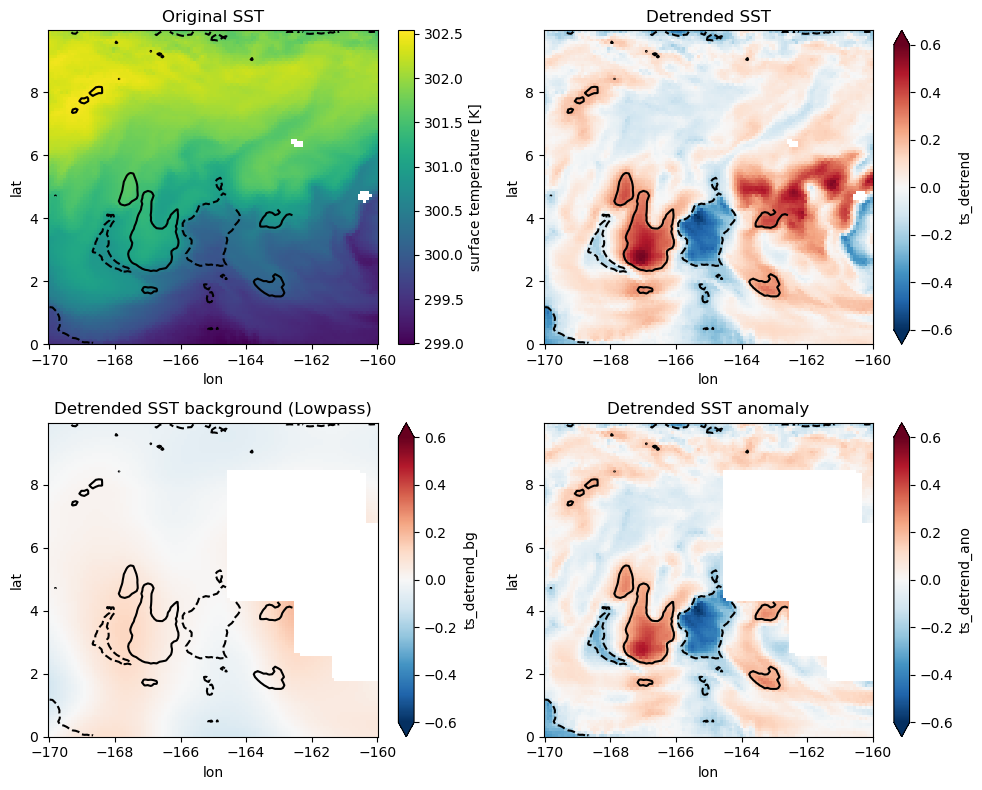

In [5]:
# User settings of spatiotemporal plotting area
lat_slice = slice(0, 10)    #slice(-15, 15)
lon_slice = slice(-170, -160)   #slice(140, 180)
time_index = 0
ano_range = (-3*dT_thresh, 3*dT_thresh)
ano_cmap = 'RdBu_r'

pcplot.plot_preprocessing_overview_map(
    dset.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice),
    analysis_var, dT_thresh, ano_range, ano_cmap,
    )

### Detection of SST clusters

In [6]:
dset['sst_feature'], feature_props = pcsst.extract_sst_features(
    dset['ts_detrend_ano'], threshold=dT_thresh,
    connectivity=feature_connectivity, property_list=feature_props_list,
    feature_min_area=feature_min_area
    )

### Cut out 

In [7]:
from typing import Tuple

def get_feature_centric_data_cutouts(
        dset: xr.Dataset,
        feature_props: xr.Dataset,
        search_RadRatio: float,
        ) -> Tuple[xr.Dataset, xr.Dataset, list[xr.Dataset]]:
    basic_coords = (dset['lat'], dset['lon'])

    feature_data = pcsst.cutout_feature_data(
        dset, feature_props, search_RadRatio
        )
    dset['sst_feature'], feature_props = pcsst.update_features(
        dset['sst_feature'], feature_props, feature_data,
        )
    
    feature_centric_data = pccoord.spherical2cartesian_featcen(
        basic_coords, feature_data, feature_props
        )

    feature_centric_data = pccoord.rotated_feature_centric_cartesian_coords(
        feature_centric_data, feature_props
        )
    
    return dset, feature_props, feature_centric_data


dset, feature_props, feature_centric_data = \
    get_feature_centric_data_cutouts(
        dset, feature_props, search_RadRatio
    )

feature_props = pcwind.calc_feature_bg_wind(
    feature_props, feature_centric_data, wind_vars
    )

### Visualization of the SST clusters

In [39]:
import importlib as implib
implib.reload(pcplot)

<module 'pycompo.plot' from '/home/m/m300738/libs/pycompo/pycompo/plot.py'>

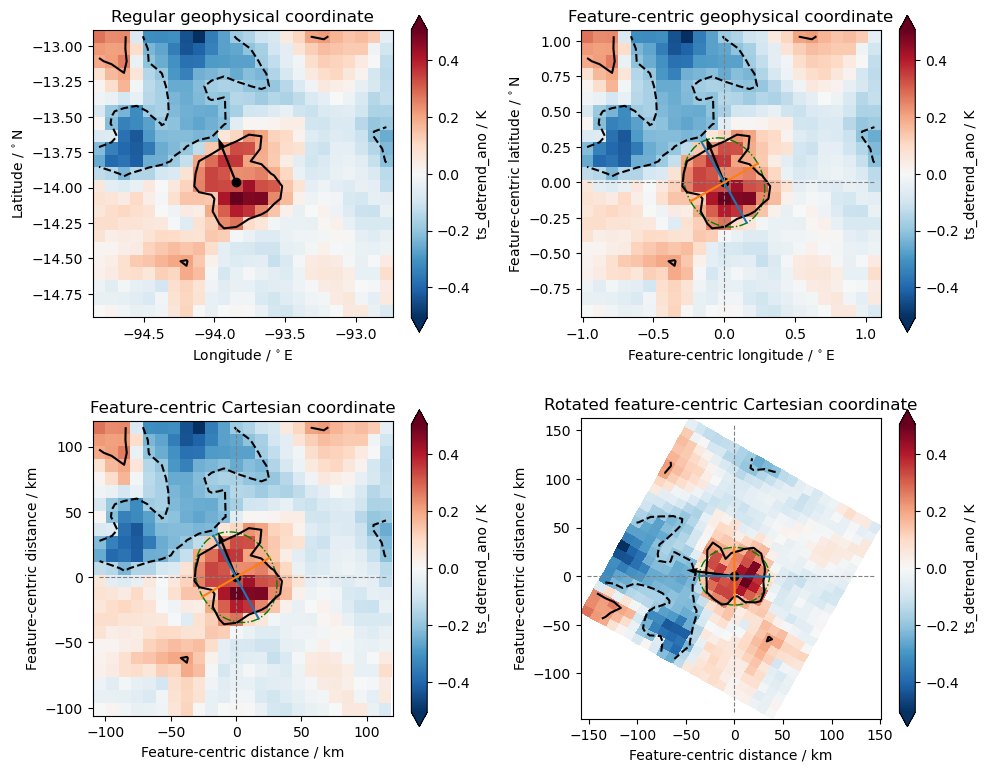

In [40]:
import matplotlib.pyplot as plt
feature_id = 0
data = feature_centric_data[feature_id]
props = feature_props.isel(feature=feature_id)
basic_coords = (dset['lat'], dset['lon'])
pcplot.plot_coord_transformation(
    data, props, basic_coords, analysis_var, dT_thresh,
    )

In [33]:
props

<xarray.Dataset>
Dimensions:                (idx_component: 2)
Coordinates:
    feature_id             int64 27
Dimensions without coordinates: idx_component
Data variables: (12/15)
    radius_km              float64 31.33
    area_km2               float64 3.084e+03
    time                   datetime64[ns] 2020-08-01
    centroid_idx           (idx_component) float64 11.3 976.0
    area_idx               float64 33.0
    axis_major_length_idx  float64 7.409
    ...                     ...
    axis_major_end_idx     (idx_component) float64 1.81 -3.232
    axis_minor_end_idx     (idx_component) float64 2.695 1.51
    bg_uas                 float64 -3.017
    bg_vas                 float64 7.485
    bg_sfcwind             float64 8.07
    bg_sfcwind_dir         float64 158.1

### Create background wind normalized natural coordinate

feature_props = pcwind.calc_feature_bg_wind(
    feature_props, feature_centric_data, wind_vars
    )

### Tasks
- Rotate the wind quantities when calculating feature centric roated coordinates